In [2]:
%matplotlib notebook
%matplotlib inline

import os
import time
import datetime as dt
import numpy as np
from numpy import newaxis
import matplotlib.pyplot as plt
import pandas
import pandas_datareader
import stock_data_preprocessing

# Load newest Google stock data from Yahoo Finance

In [3]:
#load data
start = dt.datetime(1995,1,1)
end   = dt.date.today()
data = pandas_datareader.data.DataReader('GOOG','yahoo',start,end)
data.head()

,Open,High,Low,Close,Volume,Adj Close
Date,,,,,,
2004-08-19,100.000168,104.060182,95.960165,100.340176,44871300,50.119968
2004-08-20,101.010175,109.080187,100.500174,108.310183,22942800,54.100990
2004-08-23,110.750191,113.480193,109.050183,109.400185,18342800,54.645447
2004-08-24,111.240189,111.600192,103.570177,104.870176,15319700,52.382705
2004-08-25,104.960181,108.000187,103.880180,106.000184,9232100,52.947145


# Normalise and Prepozess the data like a boss^12

In [4]:
#normalise data
data_n = stock_data_preprocessing.normalise_stock_data(data)
data_n.head()

,Ordinal/1e6,Weekday,Adj Volume,Adj Close,Adj Open,Adj High,Adj Low,Normalised Volume,Normalised Close,Normalised Open,Normalised High,Normalised Low
Date,,,,,,,,,,,,
2004-08-19,0.731812,3.0,0.543621,1.000000,0.996611,1.037074,0.956348,0.000000,0.000000,0.000000,0.000000,0.000000
2004-08-20,0.731813,4.0,0.277955,1.079430,1.006677,1.087104,1.001595,-0.722045,0.079430,0.006677,0.087104,0.001595
2004-08-23,0.731816,0.0,0.222225,1.090293,1.103747,1.130955,1.086805,-0.794127,0.010064,0.022528,0.047733,0.006832
2004-08-24,0.731817,1.0,0.185600,1.045146,1.108631,1.112218,1.032191,-0.829771,-0.041408,0.016819,0.020110,-0.053291
2004-08-25,0.731818,2.0,0.111848,1.056408,1.046043,1.076340,1.035280,-0.892983,0.010775,0.000858,0.029847,-0.009440


# 1,2,3 Plot Line!

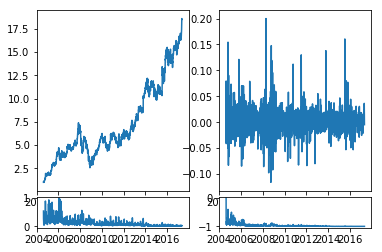

In [5]:
stock_data_preprocessing.stock_plot((data_n,))

# Pickup the Data

In [6]:
# training data
prediction_time = 1 #day
testdatasize = 450
unroll_length = 50
testdatacut = testdatasize + unroll_length  + 1

x_train = data_n[0:-prediction_time-testdatacut].as_matrix()
y_train = data_n[prediction_time:-testdatacut  ]['Normalised Close'].as_matrix()

# test data
x_test = data_n[0-testdatacut:-prediction_time].as_matrix()
y_test = data_n[prediction_time-testdatacut:  ]['Normalised Close'].as_matrix()



# unroll it

In [7]:
def unroll(data,sequence_length=24):
    result = []
    for index in range(len(data) - sequence_length):
        result.append(data[index: index + sequence_length])
    return np.asarray(result)


x_train = unroll(x_train,unroll_length)
x_test  = unroll(x_test,unroll_length)
y_train = y_train[-x_train.shape[0]:]
y_test  = y_test[-x_test.shape[0]:]


print("x_train", x_train.shape)
print("y_train", y_train.shape)
print("x_test", x_test.shape)
print("y_test", y_test.shape)

x_train (2649, 50, 12)
y_train (2649,)
x_test (450, 50, 12)
y_test (450,)


# Go! (with Python 3.5, Keras 1.2.2 and Tensorflow 1.0, better on AWS)

In [9]:
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
import lstm, time #helper libraries

Using Theano backend.


In [10]:
#Step 2 Build Model
model = Sequential()

model.add(LSTM(
    input_dim=x_train.shape[-1],
    output_dim=50,
    return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(
    100,
    return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(
    output_dim=1))
model.add(Activation('linear'))

start = time.time()
model.compile(loss='mse', optimizer='rmsprop')
print('compilation time : {}'.format(time.time() - start))

/Users/Lanbig/anaconda/envs/dlnd/lib/python3.6/site-packages/ipykernel/__main__.py:7: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
/Users/Lanbig/anaconda/envs/dlnd/lib/python3.6/site-packages/ipykernel/__main__.py:7: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(return_sequences=True, input_shape=(None, 12), units=50)`
/Users/Lanbig/anaconda/envs/dlnd/lib/python3.6/site-packages/ipykernel/__main__.py:16: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units=1)`


compilation time : 0.015709877014160156


In [11]:
#Step 3 Train the model
model.fit(
    x_train,
    y_train,
    batch_size=3028,
    nb_epoch=350,
    validation_split=0.05)

/Users/Lanbig/anaconda/envs/dlnd/lib/python3.6/site-packages/keras/models.py:837: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '
WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'


Train on 2516 samples, validate on 133 samples
Epoch 1/350
2516/2516 [==============================] - 12s - loss: 0.0204 - val_loss: 1.0966
Epoch 2/350
2516/2516 [==============================] - 9s - loss: 1.0373 - val_loss: 3.8475e-04
Epoch 3/350
2516/2516 [==============================] - 8s - loss: 0.0183 - val_loss: 0.0100
Epoch 4/350
2516/2516 [==============================] - 9s - loss: 0.0127 - val_loss: 0.0013
Epoch 5/350
2516/2516 [==============================] - 9s - loss: 0.0108 - val_loss: 0.0016
Epoch 6/350
2516/2516 [==============================] - 9s - loss: 0.0101 - val_loss: 7.5761e-04
Epoch 7/350
2516/2516 [==============================] - 8s - loss: 0.0097 - val_loss: 7.7163e-04
Epoch 8/350
2516/2516 [==============================] - 8s - loss: 0.0095 - val_loss: 3.6976e-04
Epoch 9/350
2516/2516 [==============================] - 8s - loss: 0.0098 - val_loss: 6.0254e-04
Epoch 10/350
2516/2516 [==============================] - 9s - loss: 0.0093 - val_loss

2516/2516 [==============================] - 9s - loss: 0.0023 - val_loss: 0.0017
Epoch 87/350
2516/2516 [==============================] - 9s - loss: 0.0023 - val_loss: 0.0015
Epoch 88/350
2516/2516 [==============================] - 9s - loss: 0.0023 - val_loss: 0.0012
Epoch 89/350
2516/2516 [==============================] - 9s - loss: 0.0022 - val_loss: 0.0014
Epoch 90/350
2516/2516 [==============================] - 9s - loss: 0.0022 - val_loss: 0.0015
Epoch 91/350
2516/2516 [==============================] - 9s - loss: 0.0024 - val_loss: 0.0017
Epoch 92/350
2516/2516 [==============================] - 9s - loss: 0.0025 - val_loss: 0.0021
Epoch 93/350
2516/2516 [==============================] - 9s - loss: 0.0025 - val_loss: 0.0021
Epoch 94/350
2516/2516 [==============================] - 9s - loss: 0.0025 - val_loss: 0.0014
Epoch 95/350
2516/2516 [==============================] - 9s - loss: 0.0023 - val_loss: 0.0012
Epoch 96/350
2516/2516 [==============================] - 9s - 

2516/2516 [==============================] - 9s - loss: 7.6155e-04 - val_loss: 4.7735e-04
Epoch 168/350
2516/2516 [==============================] - 9s - loss: 7.4941e-04 - val_loss: 4.0306e-04
Epoch 169/350
2516/2516 [==============================] - 8s - loss: 7.5998e-04 - val_loss: 2.5986e-04
Epoch 170/350
2516/2516 [==============================] - 8s - loss: 7.0888e-04 - val_loss: 4.0840e-04
Epoch 171/350
2516/2516 [==============================] - 9s - loss: 7.1654e-04 - val_loss: 4.1014e-04
Epoch 172/350
2516/2516 [==============================] - 9s - loss: 6.9097e-04 - val_loss: 2.9291e-04
Epoch 173/350
2516/2516 [==============================] - 9s - loss: 6.3571e-04 - val_loss: 2.6843e-04
Epoch 174/350
2516/2516 [==============================] - 9s - loss: 6.1900e-04 - val_loss: 2.3543e-04
Epoch 175/350
2516/2516 [==============================] - 9s - loss: 5.3379e-04 - val_loss: 1.9910e-04
Epoch 176/350
2516/2516 [==============================] - 9s - loss: 5.1799e-

2516/2516 [==============================] - 9s - loss: 4.1516e-04 - val_loss: 1.6576e-04
Epoch 246/350
2516/2516 [==============================] - 9s - loss: 4.2175e-04 - val_loss: 1.6655e-04
Epoch 247/350
2516/2516 [==============================] - 9s - loss: 4.1638e-04 - val_loss: 1.6664e-04
Epoch 248/350
2516/2516 [==============================] - 9s - loss: 4.1502e-04 - val_loss: 1.6689e-04
Epoch 249/350
2516/2516 [==============================] - 9s - loss: 4.2317e-04 - val_loss: 1.6760e-04
Epoch 250/350
2516/2516 [==============================] - 9s - loss: 4.1743e-04 - val_loss: 1.7123e-04
Epoch 251/350
2516/2516 [==============================] - 9s - loss: 4.1951e-04 - val_loss: 1.7301e-04
Epoch 252/350
2516/2516 [==============================] - 9s - loss: 4.3832e-04 - val_loss: 1.8879e-04
Epoch 253/350
2516/2516 [==============================] - 9s - loss: 4.5856e-04 - val_loss: 2.2230e-04
Epoch 254/350
2516/2516 [==============================] - 9s - loss: 4.8630e-

2516/2516 [==============================] - 11s - loss: 4.0931e-04 - val_loss: 1.6689e-04
Epoch 324/350
2516/2516 [==============================] - 12s - loss: 4.0878e-04 - val_loss: 1.6691e-04
Epoch 325/350
2516/2516 [==============================] - 11s - loss: 4.0750e-04 - val_loss: 1.6819e-04
Epoch 326/350
2516/2516 [==============================] - 12s - loss: 4.0763e-04 - val_loss: 1.6949e-04
Epoch 327/350
2516/2516 [==============================] - 12s - loss: 4.1540e-04 - val_loss: 1.7130e-04
Epoch 328/350
2516/2516 [==============================] - 11s - loss: 4.1635e-04 - val_loss: 1.7629e-04
Epoch 329/350
2516/2516 [==============================] - 12s - loss: 4.1627e-04 - val_loss: 1.6980e-04
Epoch 330/350
2516/2516 [==============================] - 11s - loss: 4.1684e-04 - val_loss: 1.6967e-04
Epoch 331/350
2516/2516 [==============================] - 11s - loss: 4.1647e-04 - val_loss: 1.6805e-04
Epoch 332/350
2516/2516 [==============================] - 11s - loss

# Same Model & some (~ x10) fewer Loss !!! :) 

yo


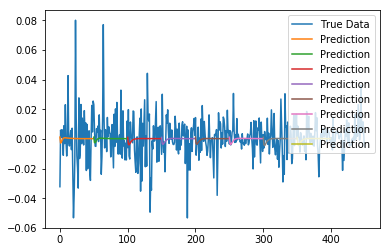

In [12]:
#Step 4 - Plot the predictions!
predictions = lstm.predict_sequences_multiple(model, x_test, 50, 50)
lstm.plot_results_multiple(predictions, y_test, 50)